Import Libraries

In [1]:
import os
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import scikitplot as skplt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool

In [2]:
warnings.filterwarnings("ignore")
data_dir = 'data/'
model_dir = 'models/'

In [3]:
# Read data
train_pos = pd.read_csv(data_dir+'train-positive.txt', header=None)
train_neg = pd.read_csv(data_dir+'train-negative.txt', header=None)
test_pos = pd.read_csv(data_dir+'test-positive.txt', header=None)
test_neg = pd.read_csv(data_dir+'test-negative.txt', header=None)

train_pos = pd.DataFrame([train_pos[::2].reset_index(drop=True)[0], train_pos[1::2].reset_index(drop=True)[0]]).T
train_neg = pd.DataFrame([train_neg[::2].reset_index(drop=True)[0], train_neg[1::2].reset_index(drop=True)[0]]).T
test_pos = pd.DataFrame([test_pos[::2].reset_index(drop=True)[0], test_pos[1::2].reset_index(drop=True)[0]]).T
test_neg = pd.DataFrame([test_neg[::2].reset_index(drop=True)[0], test_neg[1::2].reset_index(drop=True)[0]]).T


Data preprocessing

In [4]:
# Clean data to get sequences and their labels.
#df = train_pos.append(train_neg).append(test_pos).append(test_neg).reset_index(drop=True)
df = pd.concat([train_pos,train_neg,test_pos,test_neg]).reset_index(drop=True)
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: x.split(' ')[0][1:])
df.columns = ['bitter', 'seq']
labels = df.bitter.apply(lambda x: 1 if x=='Positive' else 0).values
seq = df.seq.values

In [5]:
# Encoder for creating 2D vectors from amino-acid descriptors.
descriptors = list(set([j for i in seq for j in i]))
aminoacid_encoder = OneHotEncoder(handle_unknown = 'ignore')
X = np.array(descriptors).reshape((-1, 1))
enc_arrays = aminoacid_encoder.fit(X)

In [6]:
def create_graph_data(str, label):
    """Create input graph data for Pytorch Geometric model."""
    n = len(str) # length of peptide
    # each peptide graph has n nodes and 2*(n-1) edges (bidirectional- up and down)
    edge_index_up = [[i, i+1] for i in range(n-1)] 
    edge_index_down = [[i+1, i] for i in range(n-1)] 
    edge_index = torch.tensor(edge_index_down + edge_index_up, dtype=torch.long)

    node_feats = aminoacid_encoder.transform([[i] for i in str]).toarray()
    node_features = torch.tensor(node_feats, dtype=torch.float).requires_grad_()
    label = torch.tensor(label)
    d = Data(x = node_features, edge_index=edge_index.t().contiguous(), y = label)

    return(d)

# Create graphs from the sequences. 
data_list = []
for i in range(len(labels)):
    d = create_graph_data(seq[i], labels[i])
    data_list.append(d)

GCN

In [7]:
# Create train and test data
train_data, test_data = train_test_split(data_list, test_size=1, random_state=6)

data_loader = DataLoader(data_list, batch_size=64)
train_loader = DataLoader(train_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

In [8]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(20, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)

        # Placeholdes for Grad-CAM
        self.gradients = None
        self.activations = None
    
    def activations_hook(self,grad):
        self.gradients = grad

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x1 = self.conv1(x, edge_index)
        x1 = x1.relu()
        x2 = self.conv2(x1, edge_index)
        x2 = x2.relu()
        x3 = self.conv3(x2, edge_index)

        # Save the activations
        self.activations = x3

        # Register the hook
        h = x3.register_hook(self.activations_hook)
        
        # 2. Readout layer [batch_size, hidden_channels]
        x = (
            global_max_pool(x3, batch)
            + global_add_pool(x3, batch)
            + global_mean_pool(x3, batch)
        )  # [batch_size, hidden_channels]
        
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.lin(x)

        return x.squeeze()
    
    # Gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # Activation extraction
    def get_activations(self,x):
        return self.activations

Train

In [9]:
hidden_channels = 16
epochs = 10
model = GCN(hidden_channels=hidden_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         optimizer.zero_grad()  # Clear gradients.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  # Predict the labels.
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

for epoch in range(epochs):
    train()
    acc = test(train_loader)
torch.save(model.state_dict(), 'GCN_model.pt')


In [10]:
# Define the functions to transform activations and gradients into weights per molecule
# Grad-CAM;
def grad_cam(activations, gradients):
    node_heat_map = []
    alphas = torch.mean(gradients, axis=0) # mean gradient for each neuron
    for n in range(activations.shape[0]): # nth node
        node_heat = F.relu(alphas @ activations[n]).item()
        node_heat_map.append(node_heat)
    return node_heat_map

In [11]:
import networkx as nx
def nx_graph(seq):
    descriptors = list(seq)
    G = nx.Graph()
    for ind, am in enumerate(descriptors):
        G.add_node(ind,amin = am)
        if ind != len(descriptors)-1:
            G.add_edge(ind,ind+1)
    return G

Peptide: RPFFRPFFRPFF
Predicted class: 1


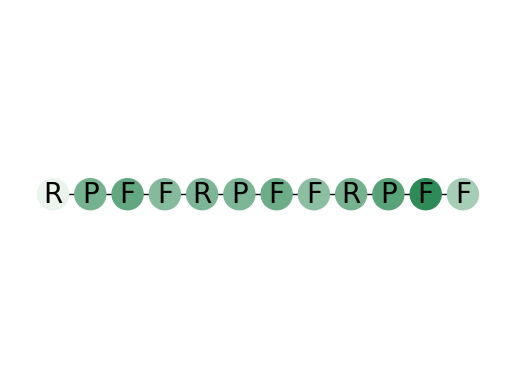

<Figure size 1600x900 with 0 Axes>

Peptide: RPFFRPFF
Predicted class: 1


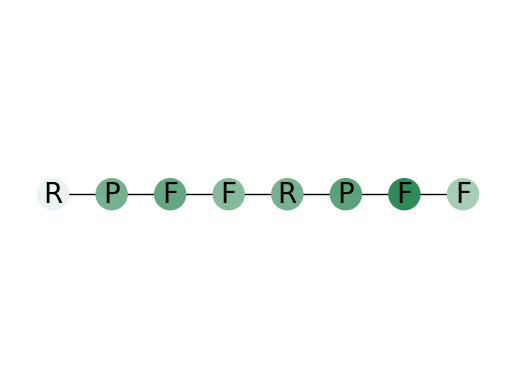

<Figure size 1600x900 with 0 Axes>

Peptide: FFRPFFRPFF
Predicted class: 1


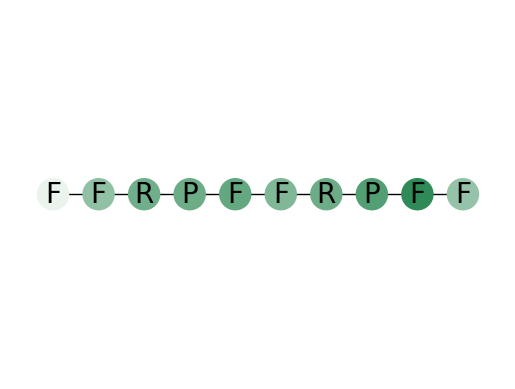

<Figure size 1600x900 with 0 Axes>

Peptide: RGPPFFF
Predicted class: 1


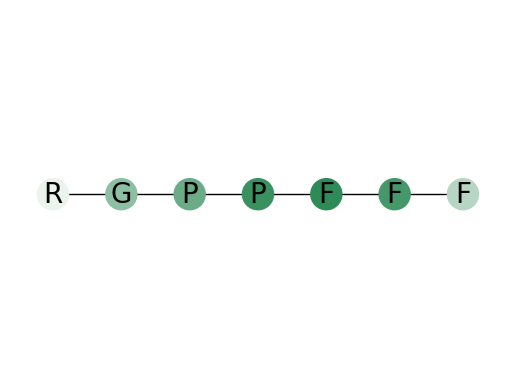

<Figure size 1600x900 with 0 Axes>

Peptide: RPPPFFF
Predicted class: 1


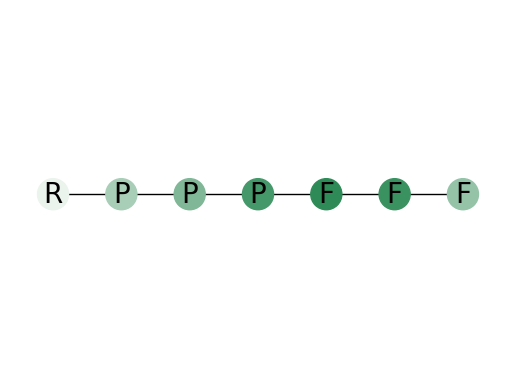

<Figure size 1600x900 with 0 Axes>

Peptide: RRPPPFFF
Predicted class: 1


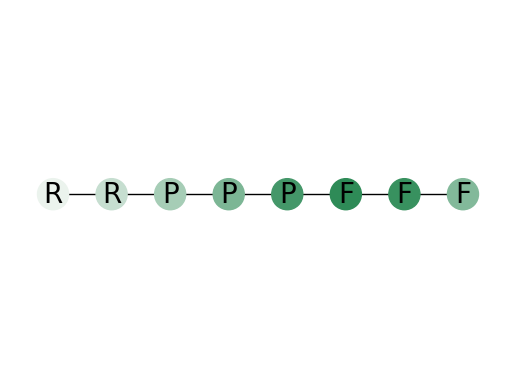

<Figure size 1600x900 with 0 Axes>

Peptide: FFF
Predicted class: 1


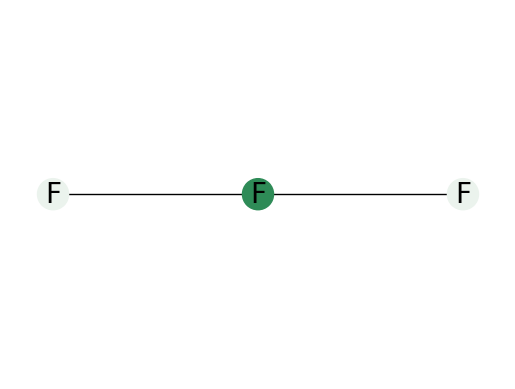

<Figure size 1600x900 with 0 Axes>

Peptide: RGPPGGGFF
Predicted class: 1


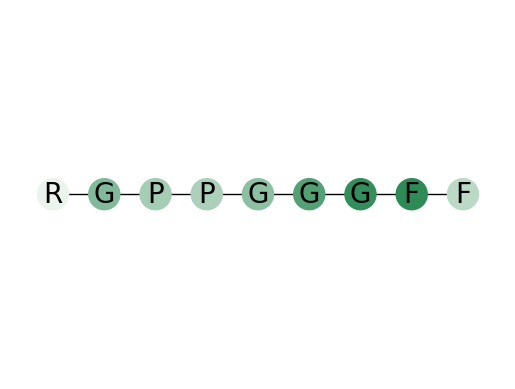

<Figure size 1600x900 with 0 Axes>

Peptide: RPGGFF
Predicted class: 1


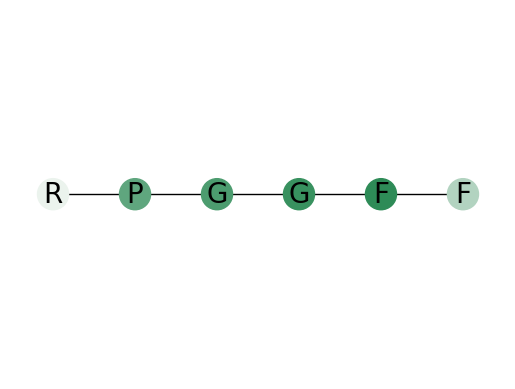

<Figure size 1600x900 with 0 Axes>

Peptide: RGPPGFF
Predicted class: 1


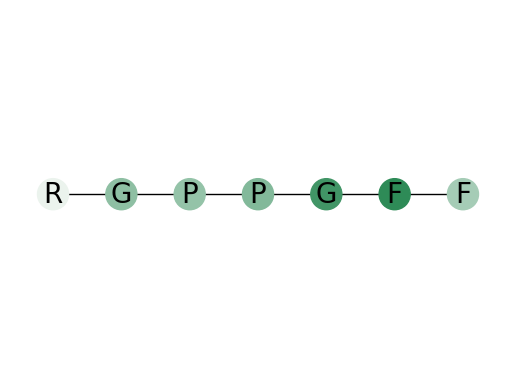

<Figure size 1600x900 with 0 Axes>

Peptide: GFF
Predicted class: 1


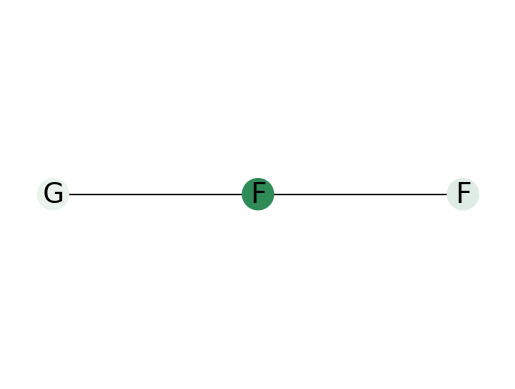

<Figure size 1600x900 with 0 Axes>

Peptide: GGFF
Predicted class: 1


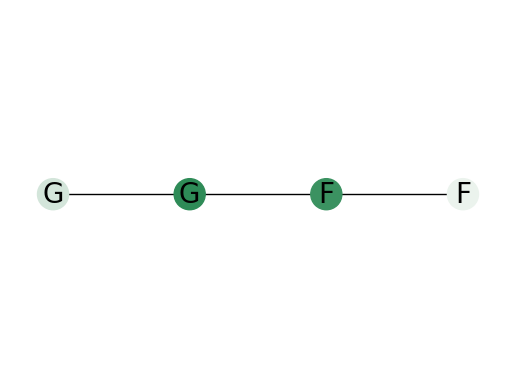

<Figure size 1600x900 with 0 Axes>

Peptide: RPGFF
Predicted class: 1


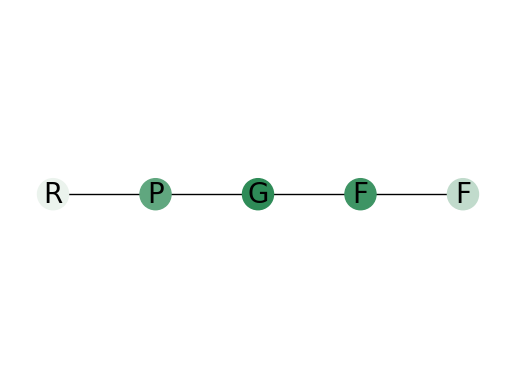

<Figure size 1600x900 with 0 Axes>

Peptide: GGFFGG
Predicted class: 1


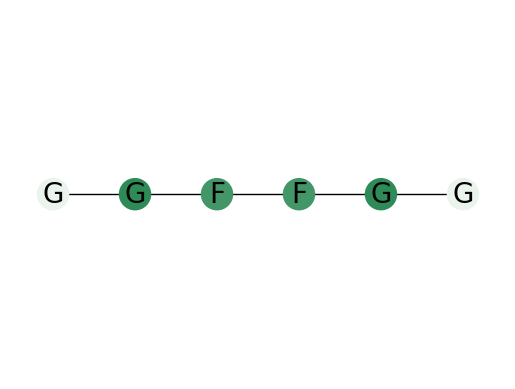

<Figure size 1600x900 with 0 Axes>

Peptide: RGPPGGFF
Predicted class: 1


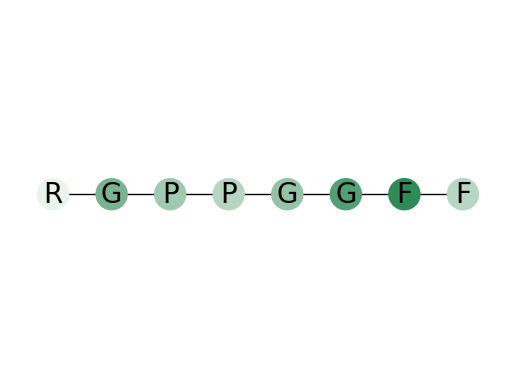

<Figure size 1600x900 with 0 Axes>

Peptide: RGFF
Predicted class: 1


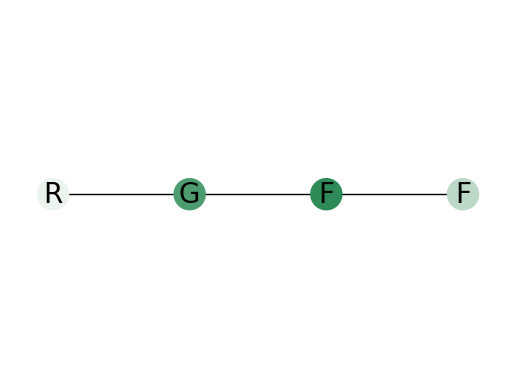

<Figure size 1600x900 with 0 Axes>

Peptide: WWW
Predicted class: 1


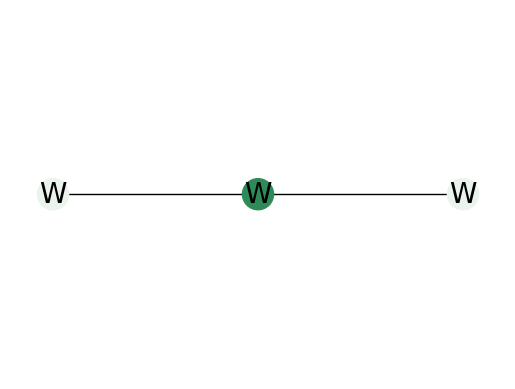

<Figure size 1600x900 with 0 Axes>

In [12]:
#External Test Set
model = GCN(hidden_channels=hidden_channels)
model.load_state_dict(torch.load('GCN_model.pt'),strict=False)
model.eval()

generated_peptides = pd.read_csv(data_dir+'tested_motifs_peptides.csv', header=None, sep=';')
seq_generated_peptides = generated_peptides[0]
labels_generated_peptides = generated_peptides[1]

data_list_predictions = []
for i in range(len(generated_peptides)):
    d = create_graph_data(seq_generated_peptides[i], labels_generated_peptides[i])
    data_list_predictions.append(d)

def predict_with_gcn(loader): 
    for ind, data in enumerate(loader):  
        output = model(data.x, data.edge_index, data.batch)
        predictions = np.argmax(output.detach().numpy())
        print(f'Peptide: {seq_generated_peptides[ind]}')
        print(f'Predicted class: {predictions}')
        output[predictions].backward()
        # pull the gradients out of the model
        gradients = model.get_activations_gradient()
        # get the activations of the last convolutional layer
        activations = model.get_activations(data.x)
        heat_map = grad_cam(activations, gradients)
        heat_map = MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(heat_map).reshape(-1, 1)).reshape(-1, )
        labeldict=list(seq_generated_peptides[ind])
        graph = nx_graph(seq_generated_peptides[ind])
        colorscale = sns.light_palette("seagreen_r", as_cmap=True) if predictions == 0 else sns.light_palette("seagreen", as_cmap=True)
        pos = {}
        for i in range(12):
            pos[i] = np.array([i,0])
        nx.draw_networkx_nodes(graph,pos,cmap=plt.get_cmap(colorscale),node_color=heat_map,vmin=0,vmax=1,node_size=500)
        nx.draw_networkx_edges(graph,pos,edge_color='black',width=1,node_size=500)
        labels= {n:k for n,k in enumerate(labeldict)}
        nx.draw_networkx_labels(graph,pos,labels=labels, font_size=20)
        plt.axis('off')
        plt.figure(figsize=(16,9))
        plt.show()
 
generated_peptides_loader = DataLoader(data_list_predictions, batch_size=1)
generated_peptides_predictions = predict_with_gcn(generated_peptides_loader)



In [45]:
out = []
lab = []
for data in train_loader:
    o = model(data.x, data.edge_index, data.batch)
    l = data.y
    out = out + o.detach().numpy().tolist()
    lab = lab + l.detach().numpy().tolist()
    

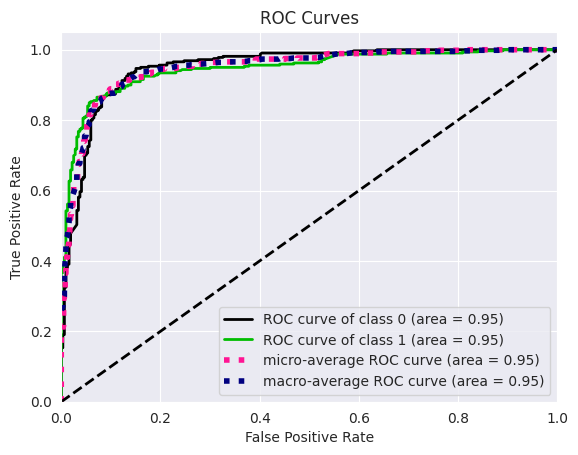

In [46]:
skplt.metrics.plot_roc(lab, out)
plt.show()

## Analysis

##### Get amino-acid level decriptor embdeddings of pos peptides.

In [47]:
def get_graph_embeddings(model, data_loader, encoder):
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    graph_embeddings = []
    for data in data_loader:
        out = model(data.x, data.edge_index, data.batch)
        lab = data.y

        model.conv3.register_forward_hook(get_activation('conv3'))
        output = model(data.x, data.edge_index, data.batch)
        conv3_feats = activation['conv3']

        for i in torch.unique(data.batch):
            node_indexes = (data.batch == i).nonzero().ravel()

            original_enc = data.x[node_indexes].detach().numpy()
            desc = ''.join(list(encoder.inverse_transform(original_enc).ravel()))

            d = {'desc':desc, 'n_nodes':len(node_indexes), 'label':lab[i].tolist(), 'pred':np.argmax(out[i].detach().numpy()), 'conv3_feats':conv3_feats[node_indexes]}
            graph_embeddings.append(d)
    return graph_embeddings
train_graph_embeddings=get_graph_embeddings(model, train_loader, aminoacid_encoder)
test_graph_embeddings=get_graph_embeddings(model, test_loader, aminoacid_encoder)
all_graph_embeddings = test_graph_embeddings + train_graph_embeddings

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x77fe07651b40>
Traceback (most recent call last):
  File "/home/ferrifnc/anaconda3/envs/bitter/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/ferrifnc/anaconda3/envs/bitter/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/ferrifnc/anaconda3/envs/bitter/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/ferrifnc/anaconda3/envs/bitter/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


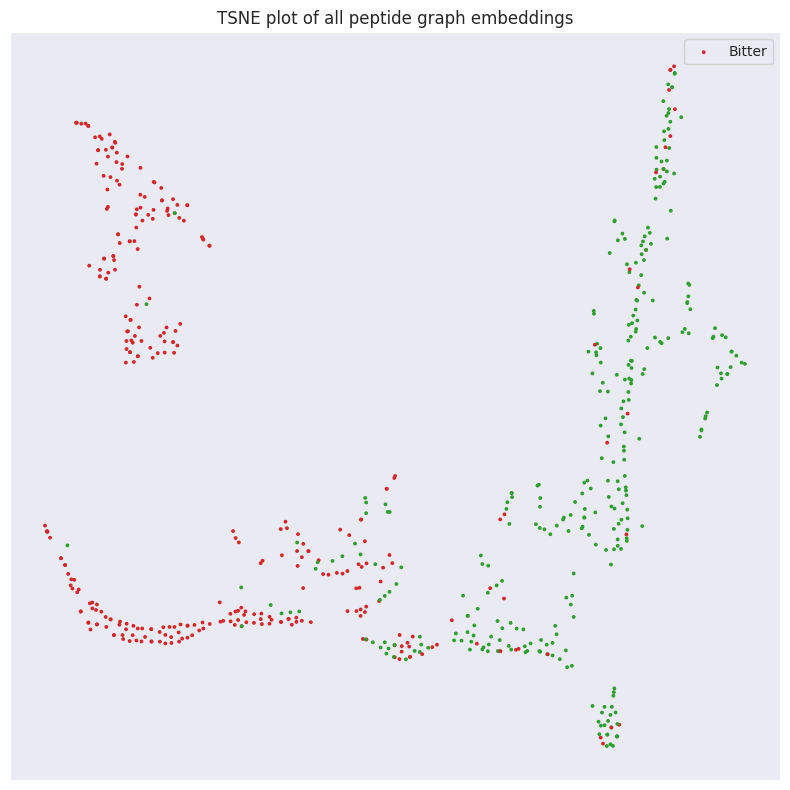

In [48]:
descs = []
conv_feats = np.zeros((len(all_graph_embeddings), 16))
labels = []
pred_vals = []
for i in range(len(all_graph_embeddings)):
    descs.append(all_graph_embeddings[i]['desc'])
    conv_feats[i] = all_graph_embeddings[i]['conv3_feats'].mean(axis = 0).detach().tolist()
    labels.append(all_graph_embeddings[i]['label'])
    pred_vals.append(all_graph_embeddings[i]['pred'])
tsne = TSNE(n_components=2, random_state=911)
tsne_embd = tsne.fit_transform(conv_feats)
plt.figure(figsize=(8, 8))
plt.scatter(tsne_embd[:, 0], tsne_embd[:, 1], c=[sns.color_palette()[x+2] for x in labels], s=3, label='Bitter')
plt.legend()
plt.title('TSNE plot of all peptide graph embeddings')
plt.xticks([])
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.savefig("TSNE Embedding plot.pdf")
plt.show()


Clusters

In [49]:
clustering = KMeans(4)

# Run the fit
clustering.fit(tsne_embd)
np.unique(clustering.labels_)

# Get the results
clusters = pd.DataFrame([descs, tsne_embd[:,0], tsne_embd[:,1], clustering.labels_]).T
clusters.columns = ['desc', 'TSNE1', 'TSNE2', 'Cluster']

emb = pd.DataFrame(all_graph_embeddings)
clusters = emb.merge(clusters, on = 'desc')
clusters['acc'] = 1*(clusters.pred==clusters.label)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x77fe054332e0>
Traceback (most recent call last):
  File "/home/ferrifnc/anaconda3/envs/bitter/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/ferrifnc/anaconda3/envs/bitter/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/ferrifnc/anaconda3/envs/bitter/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/ferrifnc/anaconda3/envs/bitter/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Th

<Axes: xlabel='TSNE1', ylabel='TSNE2'>

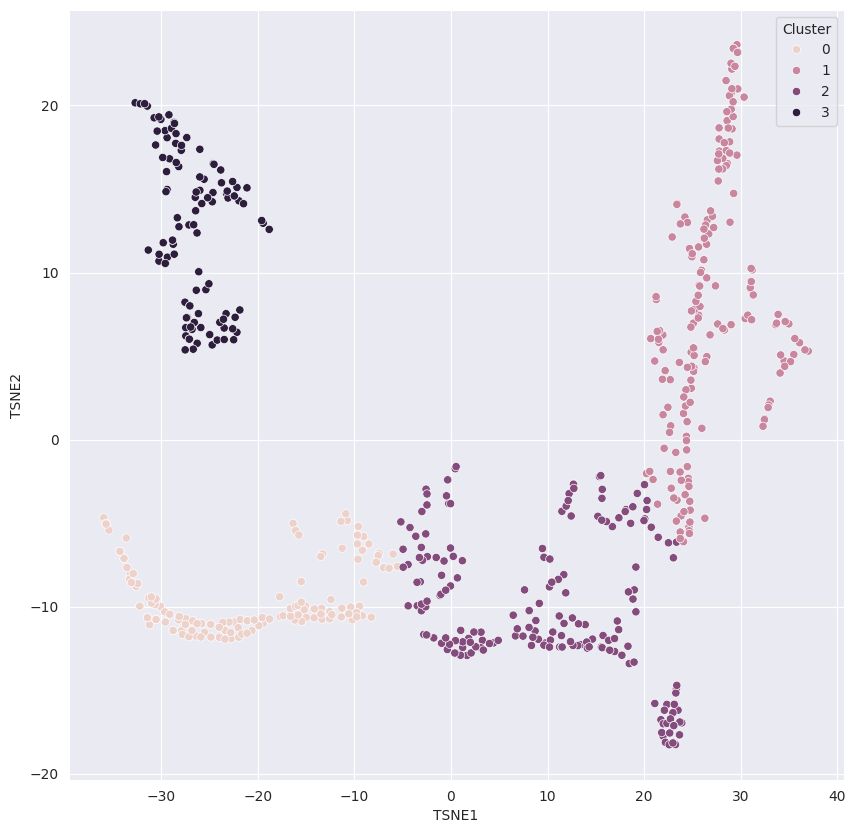

In [50]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=clusters, x="TSNE1", y="TSNE2", hue="Cluster")

In [51]:
pop=clusters[['desc', 'Cluster']]
pop.desc = pop.desc.apply(lambda x: [i for i in x])

In [52]:
clusters.groupby('Cluster').agg({'label':'sum', 'desc':'count', 'acc':'mean'})

,label,desc,acc
Cluster,,,
0,128,139,0.913669
1,16,184,0.918478
2,57,196,0.795918
3,119,121,0.983471


## Node level embeddings: All Data 

##### Amino-acid level (Mono-pep)

In [53]:
descs = []
conv_feats = []
labels = []
pred_vals = []
for i in range(len(all_graph_embeddings)):
    descs.append(all_graph_embeddings[i]['desc'])
    conv_feats.append(all_graph_embeddings[i]['conv3_feats'].mean(axis = 1).detach().tolist())
    labels.append(all_graph_embeddings[i]['label'])
    pred_vals.append(all_graph_embeddings[i]['pred'])


In [54]:
for k in range(len(all_graph_embeddings)):
    all_graph_embeddings[k]['avg_desc_act'] = all_graph_embeddings[k]['conv3_feats'].mean(axis=1)
    
desc_keys = sorted(list(set([j for i in descs for j in i])))
def get_subseq_importance(all_graph_embeddings,l=1):
    subseqs = []
    seqdict = {}
    avg_importance = []

    for i, k in enumerate(itertools.product(desc_keys, repeat=l)):
        subseqs.append(''.join(k))

    for i, d in enumerate(all_graph_embeddings):
        for j in range(len(d['desc']) - 1):
            if d['desc'][j:j+l] not in seqdict.keys():
                seqdict[d['desc'][j:j+l]] = [float(sum(d['avg_desc_act'][j:j+l])/l)]
            else:
                seqdict[d['desc'][j:j+l]] = seqdict[d['desc'][j:j+l]] + [float(sum(d['avg_desc_act'][j:j+l])/l)]

    # dict = {}
    # for k,v in seqdict.items():
    #     dict[k] = 1-np.array(v)/min(v)
    for i in subseqs:
        if i in seqdict.keys():
            avg_importance.append(np.mean(seqdict[i]))  
        else:
            avg_importance.append(0)
    return subseqs, avg_importance

In [55]:
subseqs, avg_importance= get_subseq_importance(all_graph_embeddings,l=1)


Text(0.5, 1.0, 'Average BitterGCN embedding outputs for bitter and non-bitter peptide descriptors')

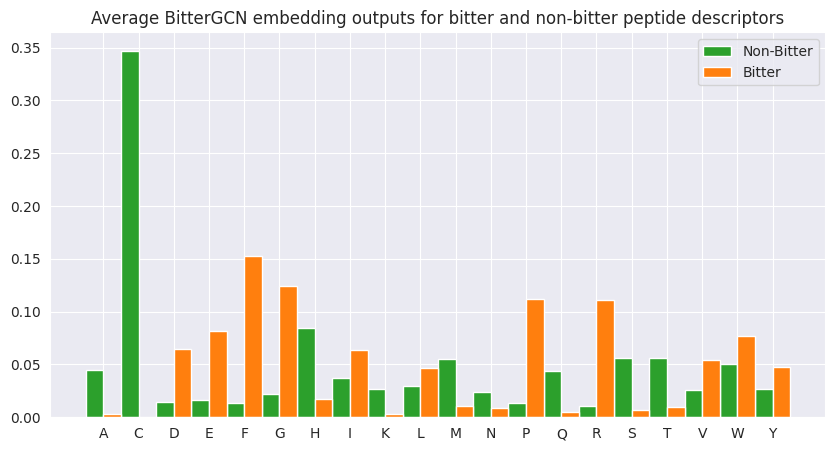

In [56]:
# Mono-peptides
# Avg
subseqs, avg_importance= get_subseq_importance(all_graph_embeddings,l=1)
monopeps = pd.DataFrame([subseqs, avg_importance], index=['pep', 'Imp']).T

# Pos
pos_graphs = [i for i in all_graph_embeddings if i['label']==1]
possubseqs, posavg_importance= get_subseq_importance(pos_graphs,l=1)
posavg_importance = np.abs(posavg_importance)
posmonopeps = pd.DataFrame([subseqs, posavg_importance], index=['pep', 'Imp']).T

# Neg
neg_graphs = [i for i in all_graph_embeddings if i['label']==0]
negsubseqs, negavg_importance= get_subseq_importance(neg_graphs,l=1)
negmonopeps = pd.DataFrame([subseqs, negavg_importance], index=['pep', 'Imp']).T
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.bar(x=np.arange(20)-0.25, height = np.abs(negmonopeps.Imp)/sum(np.abs(negmonopeps.Imp)), width=-.5, color=sns.color_palette()[2])
ax.bar(x=np.arange(20)+0.25, height = np.abs(posmonopeps.Imp)/sum(np.abs(posmonopeps.Imp)), width=-.5, color=sns.color_palette()[1])
ax.set_xticks(np.arange(20), desc_keys)
ax.legend(['Non-Bitter', 'Bitter'])
ax.set_title('Average BitterGCN embedding outputs for bitter and non-bitter peptide descriptors')

In [57]:
# Di-peptides
subseqs, avg_importance= get_subseq_importance(all_graph_embeddings,l=2)
dipeps = pd.DataFrame([subseqs, avg_importance]).T
dipeps.columns = ['pep', 'Imp']

# Pos Di-peptides
pos_graphs = [i for i in all_graph_embeddings if i['label']==1]
possubseqs, posavg_importance= get_subseq_importance(pos_graphs,l=2)
posdipeps = pd.DataFrame([possubseqs, posavg_importance]).T
posdipeps.columns = ['pep', 'Imp']

# Neg Di-peptides
neg_graphs = [i for i in all_graph_embeddings if i['label']==0]
negsubseqs, negavg_importance= get_subseq_importance(neg_graphs,l=2)
negdipeps = pd.DataFrame([negsubseqs, negavg_importance]).T
negdipeps.columns = ['pep', 'Imp']


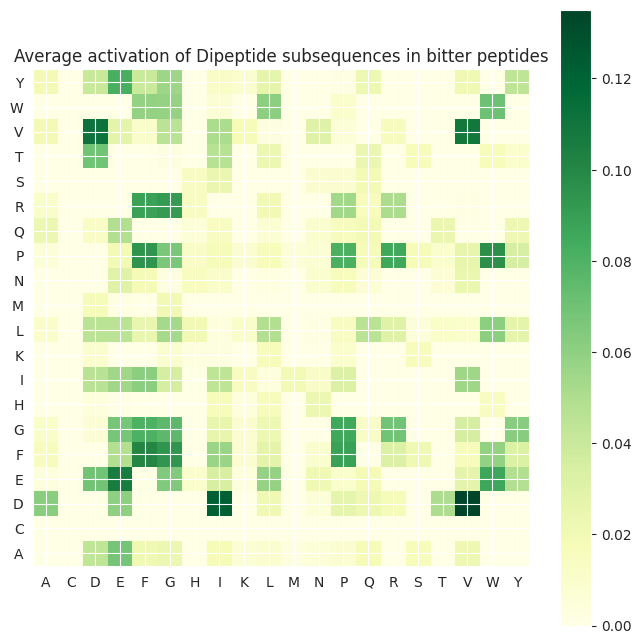

In [58]:
plt.figure(figsize=(8,8))
plt.imshow(np.rot90(np.reshape(np.abs(posdipeps['Imp'].to_list()), (20,20))),cmap='YlGn')
plt.xticks(np.arange(20), desc_keys, minor=False)
plt.yticks(np.arange(20), desc_keys[::-1])
plt.title("Average activation of Dipeptide subsequences in bitter peptides")
plt.colorbar()


In [59]:
# Tri-peptides
subseqs, avg_importance= get_subseq_importance(all_graph_embeddings,l=3)
tripeps = pd.DataFrame([subseqs, avg_importance]).T.replace(0,np.nan).dropna() # Drop values = 0
tripeps.columns = ['pep', 'Imp']
tripeps.sort_values(by='Imp', ascending=True)

# Pos Tri-peptides
pos_graphs = [i for i in all_graph_embeddings if i['label']==1]
possubseqs, posavg_importance= get_subseq_importance(pos_graphs,l=3)
postripeps = pd.DataFrame([possubseqs, posavg_importance]).T
postripeps.columns = ['pep', 'Imp']

# Neg Tri-peptides
neg_graphs = [i for i in all_graph_embeddings if i['label']==0]
negsubseqs, negavg_importance= get_subseq_importance(neg_graphs,l=3)
negtripeps = pd.DataFrame([negsubseqs, negavg_importance]).T
negtripeps.columns = ['pep', 'Imp']


In [60]:
# Tetra-peptides
subseqs, avg_importance= get_subseq_importance(all_graph_embeddings,l=4)
tetrapeps = pd.DataFrame([subseqs, avg_importance]).T.replace(0,np.nan).dropna() # Drop values = 0
tetrapeps.columns = ['pep', 'Imp']
tetrapeps.sort_values(by='Imp', ascending=False)

# Pos Tetra-peptides
pos_graphs = [i for i in all_graph_embeddings if i['label']==1]
possubseqs, posavg_importance= get_subseq_importance(pos_graphs,l=4)
postetrapeps = pd.DataFrame([possubseqs, posavg_importance]).T
postetrapeps.columns = ['pep', 'Imp']

# Neg Tetra-peptides
neg_graphs = [i for i in all_graph_embeddings if i['label']==0]
negsubseqs, negavg_importance= get_subseq_importance(neg_graphs,l=4)
negtetrapeps = pd.DataFrame([negsubseqs, negavg_importance]).T
negtetrapeps.columns = ['pep', 'Imp']

In [61]:
posallsubpeps = posdipeps.append(posmonopeps).append(postripeps).append(postetrapeps)
posallsubpeps['Imp'] = np.abs(posallsubpeps['Imp'])/np.sum(np.abs(posallsubpeps['Imp']))
posallsubpeps['len'] = posallsubpeps['pep'].apply(len)
posallsubpeps=posallsubpeps[posallsubpeps.Imp!=0]

negallsubpeps = negdipeps.append(negmonopeps).append(negtripeps).append(negtetrapeps)
negallsubpeps['Imp'] = np.abs(negallsubpeps['Imp'])/np.sum(np.abs(negallsubpeps['Imp']))
negallsubpeps['len'] = negallsubpeps['pep'].apply(len)
negallsubpeps=negallsubpeps[negallsubpeps.Imp!=0]

allsubpeps = dipeps.append(monopeps).append(tripeps).append(tetrapeps)
allsubpeps['Imp'] = np.abs(allsubpeps['Imp'])/np.sum(np.abs(allsubpeps['Imp']))
allsubpeps['len'] = allsubpeps['pep'].apply(len)
allsubpeps=allsubpeps[allsubpeps.Imp!=0]

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
#descs_qvals = pd.read_csv('data/Qvalues.csv', sep=', ')
#delf=descs_qvals.set_index('Desc').FreeEnergy.to_dict()

In [ ]:
#def get_q(x): 
#    try:
#        return np.int(sum([delf[i] for i in x])/len(x))
#    except:
#        return None

In [ ]:
posallsubpeps['Qval'] = posallsubpeps.pep.apply(lambda x: get_q(x))
posallsubpeps['Present'] = posallsubpeps.pep.isin(df.seq)
negallsubpeps['Qval'] = negallsubpeps.pep.apply(lambda x: get_q(x))
negallsubpeps['Present'] = negallsubpeps.pep.isin(df.seq)
allsubpeps['Qval'] = allsubpeps.pep.apply(lambda x: get_q(x))
allsubpeps['Present'] = allsubpeps.pep.isin(df.seq)

In [ ]:
posallsubpeps.shape

In [ ]:
negallsubpeps.shape

In [ ]:
posallsubpeps.sort_values('Imp',ascending=False)[:10]

In [ ]:
from scipy import stats

In [ ]:
stats.ttest_ind(posallsubpeps.Imp, negallsubpeps.Imp)

In [ ]:
sns.kdeplot(posallsubpeps.Imp.reset_index(drop=True))
sns.kdeplot(negallsubpeps.Imp.reset_index(drop=True))
sns.kdeplot(allsubpeps.Imp.reset_index(drop=True))

plt.legend(['Bitter','Non-bitter','All'])

In [ ]:
df['Qval']=df.seq.apply(lambda x: get_q(x))

In [ ]:
sns.kdeplot(df[df.bitter=='Positive'].Qval)
sns.kdeplot(df[df.bitter=='Negative'].Qval)

In [ ]:
clusters['Imp']=clusters.conv3_feats.apply(lambda x: x.detach().numpy().mean())

In [ ]:
sns.kdeplot(clusters[clusters.label==1].Imp)
sns.kdeplot(clusters[clusters.label==0].Imp)

In [ ]:
clusters